In [1]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn imbalanced-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 1.7 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.0 MB 1.5 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.0 MB 1.5 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.0 MB 1.5 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.0 MB 1.5 MB/s eta 0:00:


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv("/content/creditcard.csv")  # Make sure CSV path is correct


In [4]:
df['Hour'] = (df['Time'] // 3600) % 24
df['Log_Amount'] = np.log1p(df['Amount'])
df.drop(columns=['Time', 'Amount'], inplace=True)

# Separate fraud and legitimate transactions
df_fraud = df[df['Class'] == 1]
df_legit = df[df['Class'] == 0]

# Undersample majority class (~5:1 ratio)
df_legit_sampled = df_legit.sample(n=len(df_fraud)*5, random_state=42)
df_balanced = pd.concat([df_fraud, df_legit_sampled]).sample(frac=1, random_state=42)

In [5]:
# Separate features and labels
X = df_balanced.drop(columns=['Class'])
y = df_balanced['Class']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# ✅ Add this to check training data size
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Reshape for 1D CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train shape: (849, 30)
y_train shape: (849,)


In [8]:
input_layer = tf.keras.Input(shape=(X_train.shape[1], 1))
x = tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation="relu")(input_layer)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.6004243281471005), 1: np.float64(2.98943661971831)}


In [10]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,

)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 564ms/step - accuracy: 0.3081 - loss: 0.6931 - precision: 0.1468 - recall: 0.6837 - val_accuracy: 0.1784 - val_loss: 0.7310 - val_precision: 0.1635 - val_recall: 0.9714
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2540 - loss: 0.6650 - precision: 0.1377 - recall: 0.7357 - val_accuracy: 0.1784 - val_loss: 0.7289 - val_precision: 0.1635 - val_recall: 0.9714
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2879 - loss: 0.6567 - precision: 0.1708 - recall: 0.8516 - val_accuracy: 0.1831 - val_loss: 0.7275 - val_precision: 0.1675 - val_recall: 1.0000
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2867 - loss: 0.6540 - precision: 0.1900 - recall: 0.9487 - val_accuracy: 0.1737 - val_loss: 0.7250 - val_precision: 0.1659 - val_recall: 1.0000
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2750 - loss: 0.6292 - precision: 0.1806 - recall: 0.9579 - val_accuracy: 0.1784 - val_loss: 0.7218 - val_pr

In [12]:
# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate test set metrics (optional)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Test Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
print(f"Test Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
print(f"Test F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Extract per-epoch metrics from training
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Find the correct key for recall
recall_key = None
for key in history.history.keys():
    if 'recall' in key:
        recall_key = key
        break

if recall_key:
    train_recall = history.history[recall_key]
    val_recall = history.history[f'val_{recall_key}']

    # Print all metrics per epoch
    print(f"{'Epoch':<6} {'Train Acc (%)':<15} {'Val Acc (%)':<15} {'Train Loss':<12} {'Val Loss':<12} {'Train Recall (%)':<18} {'Val Recall (%)':<18}")
    for i in range(len(train_acc)):
        print(f"{i+1:<6} "
              f"{train_acc[i]*100:<15.2f} "
              f"{val_acc[i]*100:<15.2f} "
              f"{train_loss[i]:<12.4f} "
              f"{val_loss[i]:<12.4f} "
              f"{train_recall[i]*100:<18.2f} "
              f"{val_recall[i]*100:<18.2f}")
else:
    print("Could not find recall key in history.")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test Accuracy: 96.71%
Test Precision: 96.67%
Test Recall: 82.86%
Test F1 Score: 89.23%
Confusion Matrix:
 [[177   1]
 [  6  29]]
Epoch  Train Acc (%)   Val Acc (%)     Train Loss   Val Loss     Train Recall (%)   Val Recall (%)    
1      29.92           17.84           0.7012       0.7310       69.01              97.14             
2      27.92           17.84           0.6754       0.7289       78.17              97.14             
3      27.56           18.31           0.6602       0.7275       86.62              100.00            
4      28.98           17.37           0.6455       0.7250       95.77              100.00            
5      28.27           17.84           0.6303       0.7218       97.18              100.00            
6      28.50           17.84           0.6285       0.7186       96.48              100.00            
7      28.62           18.31           0.6092       0.7152       97.18              100.00            
8      29

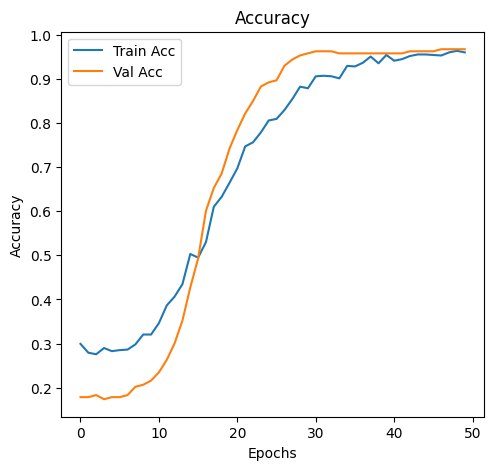

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

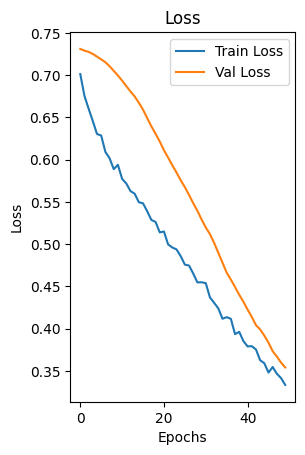

In [14]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()